# Unsupervised Clustering using DBSCAN

The notebook aims at understanding the mac addresses using a clustering algorithm to determine signals from shoppers, mall workers and stationary devices. The clustering algorithm used is called DBSCAN. The benefits of using this algorithm are that it doesn't require you to specify how many clusters and won't force the data into clusters. We also found that this data (after fine tuning the parameters) gave the best results for the three clusters we were looking for.

## Theory

DBSCAN (Density-based spatial clustering of applications with noise) is a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature [wiki](https://en.wikipedia.org/wiki/DBSCAN).

We have used the DBSCAN from the Scikit-Learn package.

## Load dependencies

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from tqdm import tqdm_notebook as tqdm

import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale

In [5]:
from msci.utils import utils
from msci.utils.plot import plot_path_jn, plot_histogram_jn, animate

In [6]:
from msci.cleaning.features import *

In [7]:
import nolds

## Import data

The dataframe `mac_address_df` contains mac addresses and the features used to cluster the mac addresses into groups. The `signal_df` contains all the *raw* signals recorded by the wifi harvesters.

In [8]:
mac_address_df = utils.import_mac_addresses(version=2)

In [9]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

153853 mac addresses with 23 features


In [10]:
# Version 1 is the raw signals
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
mac_address_df.head()

,frequency,mac_address,centroid,radius_of_gyration,manufacturer,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,...,total_path_length,av_straightness,av_speed_from_total,turning_angle_density,start_coordinate,end_coordinate,wifi_type,start_time,end_time,number_of_shops
0,4335,bc:20:10:8c:fe:05,"[248.74213763936945, 52.501230296039985]",11.995491,NaN,10.068530,86335,1,0.825589,2.020411,...,42362.930095,2.991980,0.490681,0.201646,"[255.0, 52.0]","[248.0, 56.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:59,11
1,4055,38:ff:36:2d:f1:88,"[295.42392108508017, 29.343033292231812]",16.817997,Ruckus Wireless,6.874677,86335,1,0.883485,1.945728,...,47707.740144,3.269752,0.552589,0.135730,"[295.0, 39.0]","[286.0, 24.0]",Discovered-AP,2016-12-22 00:00:04,2016-12-22 23:58:59,15
2,4017,9c:99:a0:07:5e:a9,"[254.3886399468924, 53.634096755455978]",10.123603,Xiaomi Communications Co Ltd,11.341497,86335,1,0.848751,2.028591,...,39434.334598,2.862068,0.456760,0.204123,"[256.0, 48.0]","[230.0, 58.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:59,10
3,3967,c4:f0:81:19:be:fc,"[242.23061087303589, 52.0]",8.257177,"HUAWEI TECHNOLOGIES CO.,LTD",10.431897,86284,1,0.787397,2.094878,...,36065.304793,2.904743,0.417984,0.226767,"[237.0, 55.0]","[247.0, 46.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:08,5
4,3872,e8:de:27:5e:bf:99,"[197.34969008264463, 17.058626033057852]",49.954985,"TP-LINK TECHNOLOGIES CO.,LTD.",6.602468,86089,1,2.490304,1.439609,...,138718.529544,3.392838,1.611339,0.040069,"[204.0, 17.0]","[233.0, 17.0]",Discovered-AP,2016-12-22 00:04:10,2016-12-22 23:58:59,6


## Investigation

### Data Preparation

The `FEATURE_LIST` is shown below. The clustering algorithm will use these to determine the similarity between mac addresses. The two main features include *length of stay* and *radius of gyration*. These are later shown to be very contrasting for the different clusters.

In [12]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

In [13]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [14]:
mac_address_clean_df

,frequency,mac_address,centroid,radius_of_gyration,manufacturer,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,...,total_path_length,av_straightness,av_speed_from_total,turning_angle_density,start_coordinate,end_coordinate,wifi_type,start_time,end_time,number_of_shops
0,4335,bc:20:10:8c:fe:05,"[248.74213763936945, 52.501230296039985]",11.995491,NaN,10.068530,86335,1,0.825589,2.020411,...,42362.930095,2.991980,0.490681,0.201646,"[255.0, 52.0]","[248.0, 56.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:59,11
1,4055,38:ff:36:2d:f1:88,"[295.42392108508017, 29.343033292231812]",16.817997,Ruckus Wireless,6.874677,86335,1,0.883485,1.945728,...,47707.740144,3.269752,0.552589,0.135730,"[295.0, 39.0]","[286.0, 24.0]",Discovered-AP,2016-12-22 00:00:04,2016-12-22 23:58:59,15
2,4017,9c:99:a0:07:5e:a9,"[254.3886399468924, 53.634096755455978]",10.123603,Xiaomi Communications Co Ltd,11.341497,86335,1,0.848751,2.028591,...,39434.334598,2.862068,0.456760,0.204123,"[256.0, 48.0]","[230.0, 58.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:59,10
3,3967,c4:f0:81:19:be:fc,"[242.23061087303589, 52.0]",8.257177,"HUAWEI TECHNOLOGIES CO.,LTD",10.431897,86284,1,0.787397,2.094878,...,36065.304793,2.904743,0.417984,0.226767,"[237.0, 55.0]","[247.0, 46.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:08,5
4,3872,e8:de:27:5e:bf:99,"[197.34969008264463, 17.058626033057852]",49.954985,"TP-LINK TECHNOLOGIES CO.,LTD.",6.602468,86089,1,2.490304,1.439609,...,138718.529544,3.392838,1.611339,0.040069,"[204.0, 17.0]","[233.0, 17.0]",Discovered-AP,2016-12-22 00:04:10,2016-12-22 23:58:59,6
5,3674,34:8a:7b:87:31:32,"[247.16621302848847, 63.717383414988213]",14.020458,"Samsung Electronics Co.,Ltd",8.313257,86059,1,0.847044,2.116185,...,40618.112836,3.946508,0.471980,0.186516,"[248.0, 70.0]","[243.0, 62.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:54:23,12
6,3553,58:23:8c:7f:be:34,"[285.84942302279762, 61.419223191669012]",18.520307,Technicolor CH USA Inc.,7.349572,86130,1,1.253862,1.665781,...,60920.147890,2.829966,0.707305,0.092422,"[286.0, 60.0]","[293.0, 55.0]",Discovered-AP,2016-12-22 00:03:29,2016-12-22 23:58:59,9
7,3508,54:14:73:1a:06:81,"[240.23061573546181, 54.080102622576966]",11.252712,Wingtech Group (HongKong?Limited,9.278113,86325,1,0.807759,2.119963,...,34055.851606,3.096451,0.394507,0.209843,"[254.0, 47.0]","[247.0, 57.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:49,4
8,3445,98:fc:11:eb:90:65,"[46.039090469279152, 107.86574746008708]",23.235344,"Cisco-Linksys, LLC",6.423285,86335,1,1.263622,1.857472,...,64626.800766,3.432605,0.748559,0.092548,"[31.0, 111.0]","[21.0, 112.0]",Discovered-AP,2016-12-22 00:00:04,2016-12-22 23:58:59,10
9,3420,bc:76:5e:f3:a6:cc,"[260.32733918128656, 56.641812865497073]",11.949406,"Samsung Electronics Co.,Ltd",6.103393,86335,1,0.833290,1.959983,...,42546.289310,3.410573,0.492805,0.148382,"[263.0, 54.0]","[264.0, 58.0]",unknown,2016-12-22 00:00:04,2016-12-22 23:58:59,8


In [15]:
mac_address_clean_df.describe()

,frequency,radius_of_gyration,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,total_turning_angle,av_turning_angle_velocity,av_path_length,total_path_length,av_straightness,av_speed_from_total,turning_angle_density,number_of_shops
count,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22918.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000
mean,90.468747,57.803823,2.389125,13496.505876,0.027031,0.959677,1.631721,140.822441,-0.004709,26.680050,1565.771622,2.508698,0.267569,0.072591,5.481631
std,203.302774,28.092992,1.460574,18909.551262,0.162176,1.211053,0.368645,380.482956,0.191404,16.061177,2719.687429,1.220453,0.271323,0.051978,4.884028
min,11.000000,0.944355,0.000000,87.000000,0.000000,0.000314,0.051901,0.051901,-3.119614,0.183925,16.185363,1.000000,0.000194,0.000368,0.000000
25%,17.000000,36.068601,1.303840,2180.250000,0.000000,0.433812,1.388192,22.486280,-0.049649,15.994874,539.614897,1.815382,0.101860,0.037566,2.000000
50%,38.000000,61.228510,2.121320,6124.500000,0.000000,0.621783,1.623377,48.139189,-0.000007,22.536139,1020.984014,2.262691,0.197017,0.058759,4.000000
75%,84.000000,79.033698,3.205897,14177.750000,0.000000,0.964728,1.862984,114.538730,0.049567,33.111118,1713.959765,2.863882,0.331834,0.090089,8.000000
max,4335.000000,154.812502,15.556349,86335.000000,1.000000,23.011323,3.141593,8542.296219,3.049002,161.696885,138718.529544,41.365040,3.969383,0.477567,51.000000


We need to scale each feature into a Gaussian distribution. The `scale` function is used from the scikit learn package within preprocessing.

In [16]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [17]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### DBSCAN

The initial parameters were adjusted and the top three clusters were plotted. The final parameters gave the three clusters we were looking (shopper, stationary devices, mall workers).

In [18]:
db = DBSCAN(eps=0.45, min_samples=6)
db.fit(samples)
labels = db.labels_

In [19]:
mac_address_clean_df['dbscan_label'] = labels

In [20]:
mac_address_clean_df.dbscan_label.value_counts()

-1     13240
 13     8928
 3       156
 1       143
 2        30
 56       20
 48       16
 14       15
 57       14
 42       13
 49       12
 65       11
 44       11
 17       10
 68       10
 43       10
 54        9
 19        9
 53        9
 8         9
 59        9
 55        9
 9         9
 31        9
 47        8
 6         8
 7         8
 61        8
 39        7
 22        7
       ...  
 0         6
 30        6
 24        6
 62        6
 25        6
 41        6
 15        6
 10        6
 45        6
 27        6
 58        6
 50        5
 46        5
 60        5
 12        5
 35        5
 32        5
 26        5
 67        5
 40        5
 38        5
 21        5
 11        4
 63        4
 33        4
 4         4
 29        3
 28        3
 37        3
 69        3
Name: dbscan_label, Length: 71, dtype: int64

There were also 11734 mac addresses that were not clusters. These will be investigated later to understand where we can use our initial estimates from the DBSCAN to recluster these mac addresses using a partially supervised clustering method (Naive Bayes).

In [21]:
mac_address_classified_df = mac_address_clean_df[
    (mac_address_clean_df.dbscan_label==13) | 
    (mac_address_clean_df.dbscan_label==3) | 
    (mac_address_clean_df.dbscan_label==1)
]

mac_address_classified_df['device'] = ''

mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==13, 'device'] = 'Shopper'
mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==3, 'device'] = 'Mall Worker'
mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==1, 'device'] = 'Stationary'

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
mac_address_classified_df.device.value_counts()

Shopper        8928
Mall Worker     156
Stationary      143
Name: device, dtype: int64

## Distributions

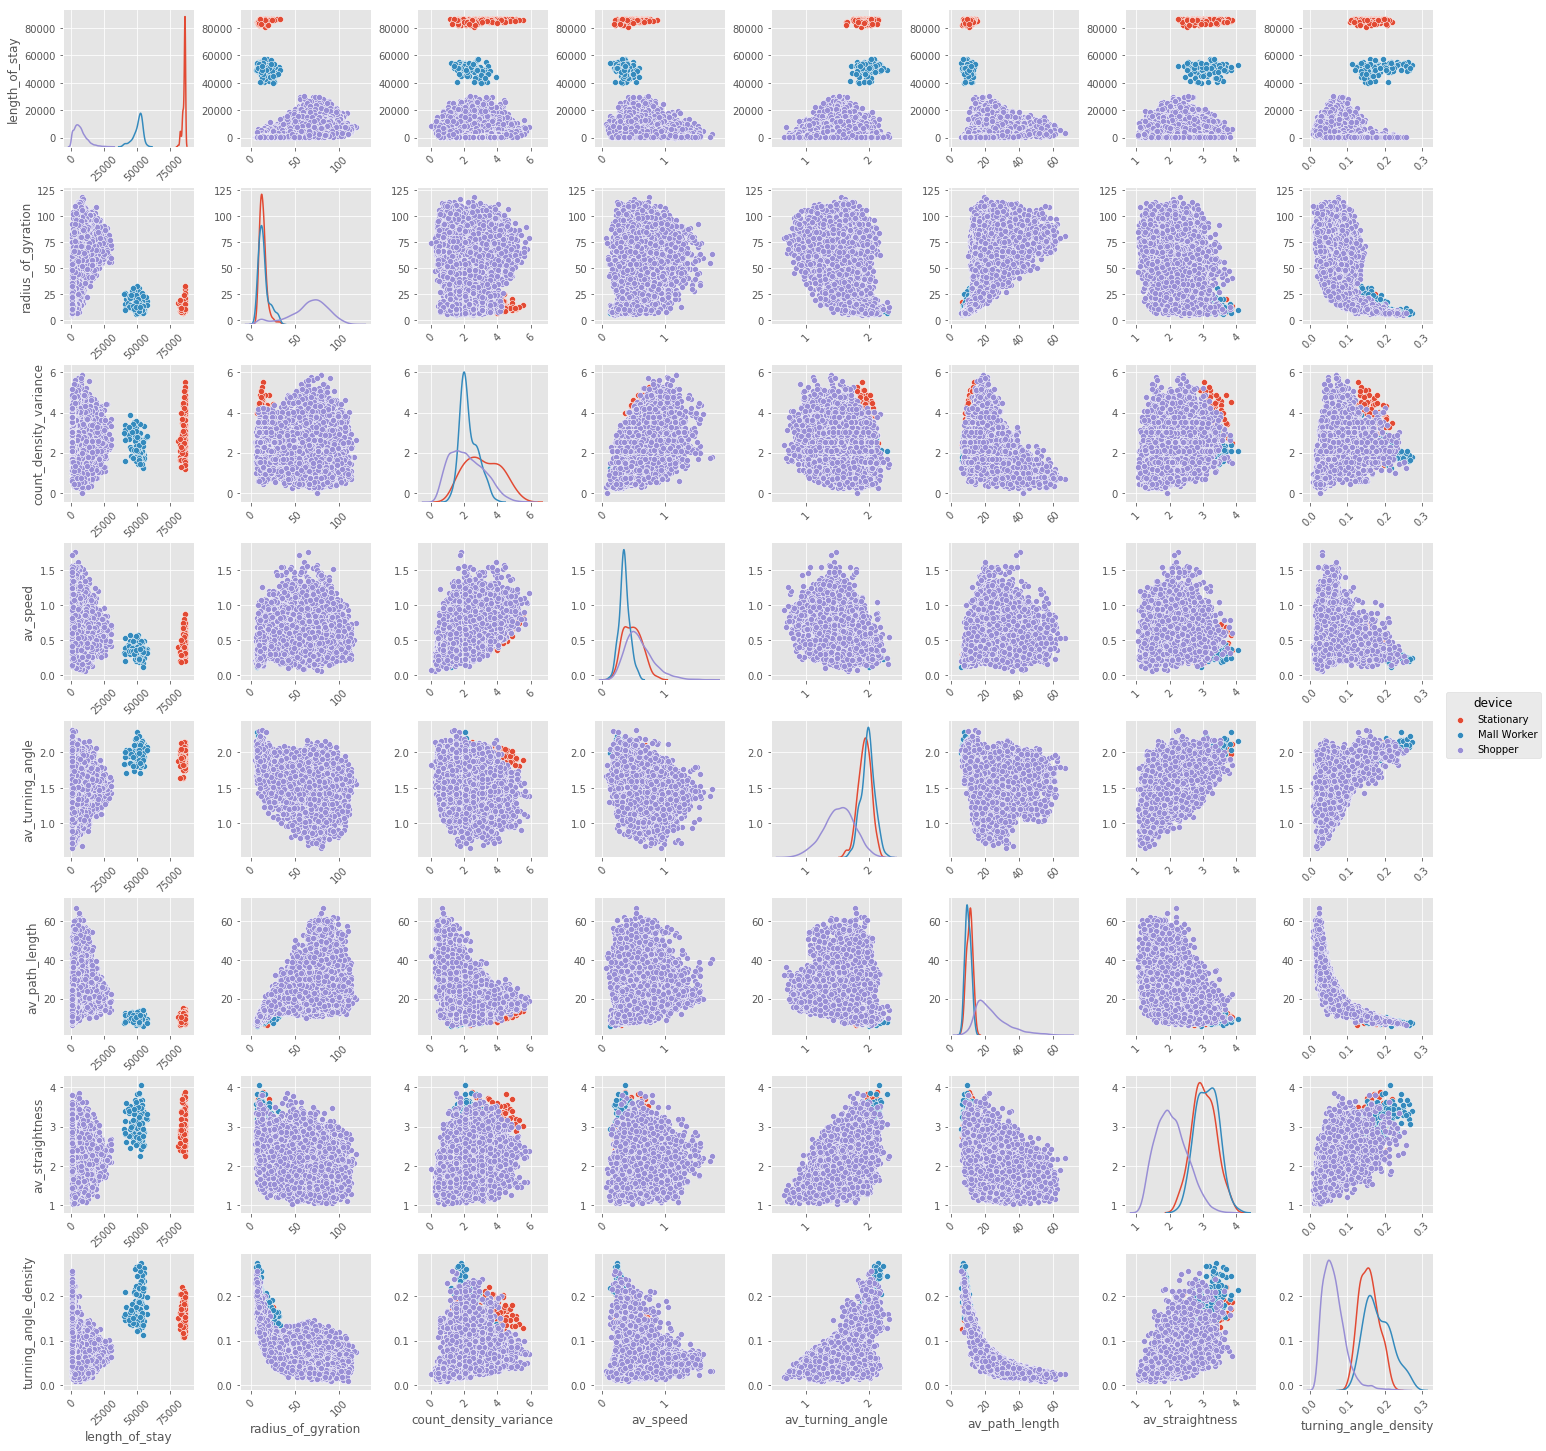

In [23]:
g = sns.pairplot(
    mac_address_classified_df,
    vars=FEATURE_LIST,
    hue="device", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

The distributions are plotted for the three clusters 

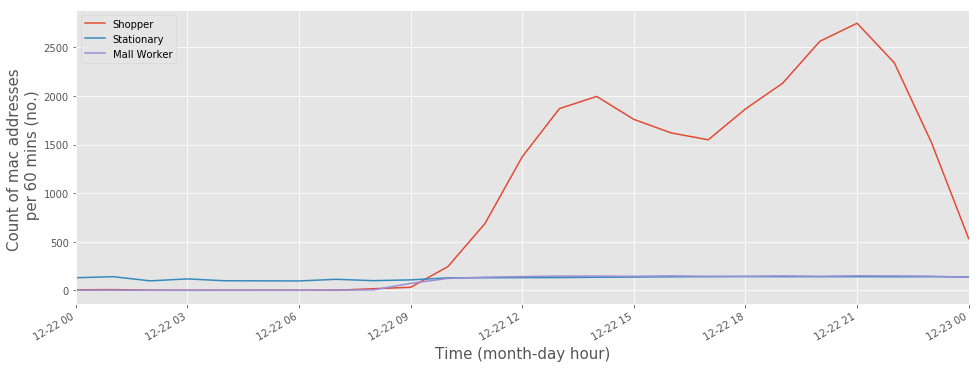

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

macs = mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Shopper',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Stationary',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Mall Worker'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Mall Worker',
);

The graphs above shows the number of devices that were seen in the mall over 15 minute intervals. The number of *Stationary devices* stays constant which is expected. The number of *Mall Workers* increases before the opening hours then stays constant until close. The number of *Shoppers* increases after the shops are open; there are two peaks around 13:30 and 21:00 **which are known to be the most busy times for the mall around Christmas (please check this)**.

## Distribution of points for stationary and mall workers (confirmation of difference)

Two plots are shown below for the stationary devices e.g. an ipad computer that has wifi in the store and mall workesr. The plots are scatters distributions of all the devices where the colour depict the denisty of the points. The yellow regions have a higher density of points and, therefore, are more likely to be where the device is located. The blue points are low density regions and are more likely to be the noice of the device.

### Distribution of stationary devices

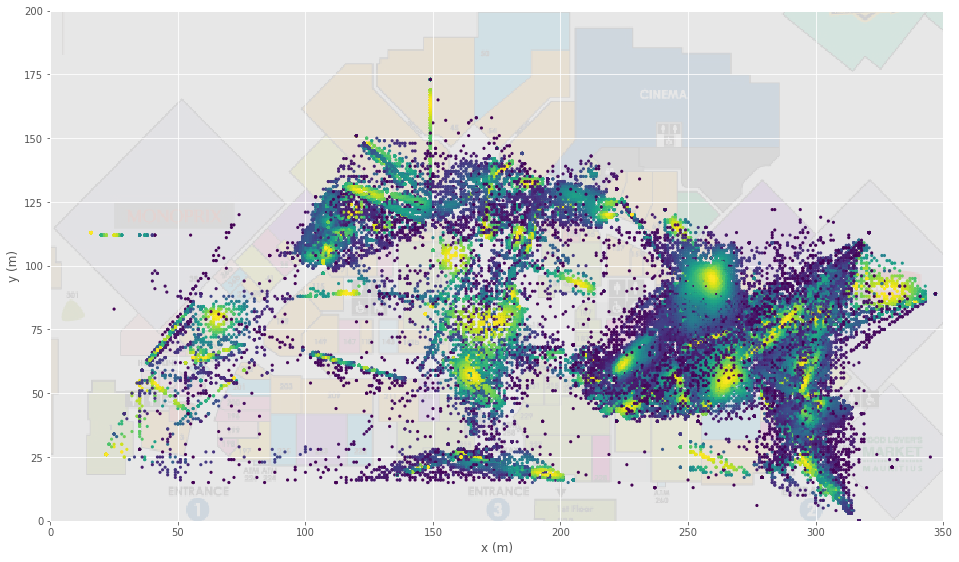

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

The map above shows a heat map of the distribution of stationary devices clustered via DBSCAN. Signals picked up from these devices are tend to have a directional uncertainty. This can be seen via the yellow regions being distributed along an axis. The right had side of the mall has a far greater uncertainty than the left due to there being more blue points.

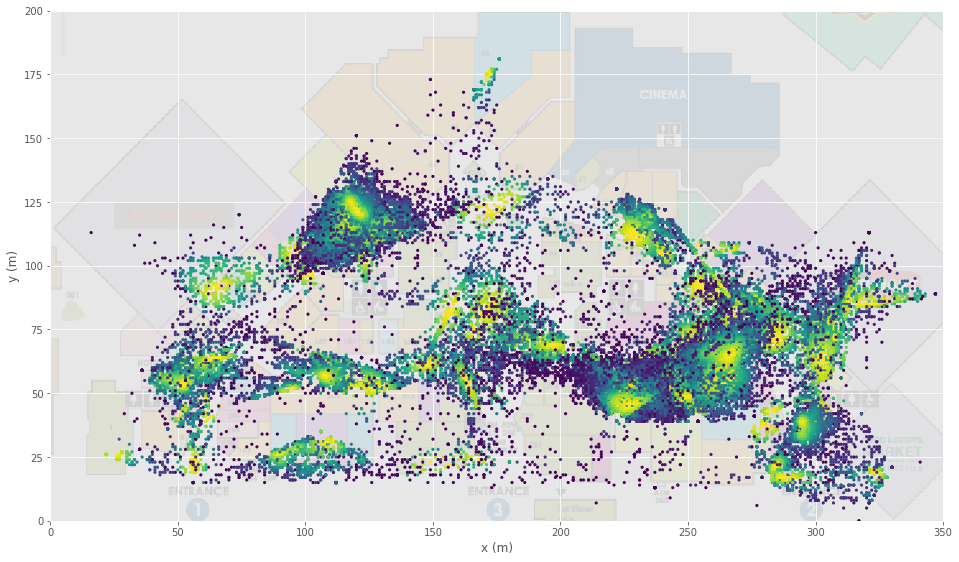

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[
        (mac_address_classified_df.device == 'Mall Worker')
    ].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

The mall staff seem to have reasonably isotropic distributions of points. The dense regions are spread evenly among the store which is expected due to mall staff being in every sttore. Again, there seems to be a greater uncertainty in the distribution around the right hand side of the graph.

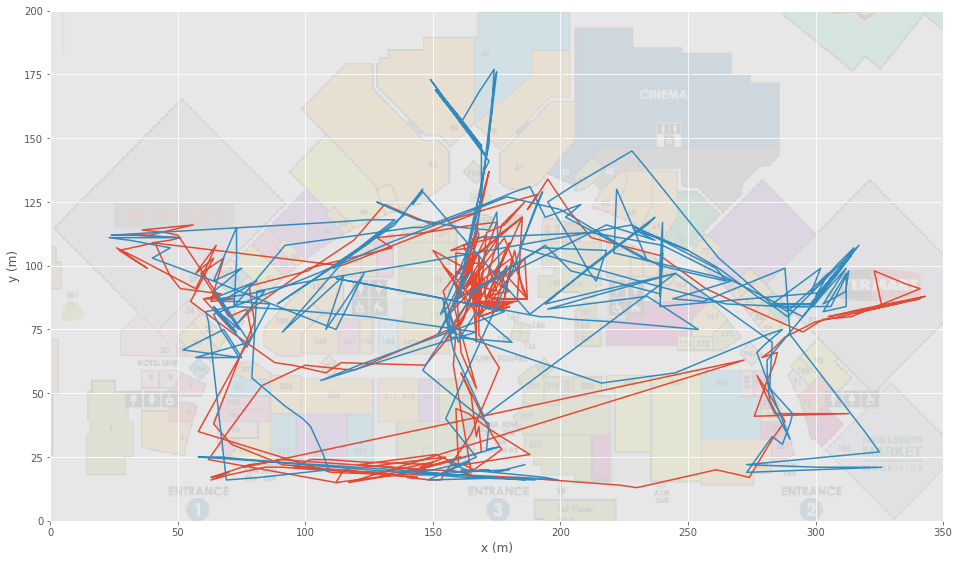

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()[5:7],
    axes=ax, 
    plot_type='', 
    label=False
)

The map of the mall with two shoppers paths shown on them. The paths shown are clearly shoppers moving around the store.

## Output the labelled data

In [28]:
output_mac_address_df = mac_address_df.copy()

output_mac_address_df['dbscan_label'] = 'Not Classified'

output_mac_address_df.dbscan_label[
    output_mac_address_df.mac_address.isin(mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address)
] = 'Shopper'

output_mac_address_df.dbscan_label[
    output_mac_address_df.mac_address.isin(mac_address_classified_df[mac_address_classified_df.device == 'Mall Worker'].mac_address)
] = 'Mall Worker'

output_mac_address_df.dbscan_label[
    output_mac_address_df.mac_address.isin(mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address)
] = 'Stationary'

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [29]:
output_mac_address_df.dbscan_label.value_counts()

Not Classified    144626
Shopper             8928
Mall Worker          156
Stationary           143
Name: dbscan_label, dtype: int64

In [30]:
output_mac_address_df.to_csv('mauritius_featuresv3.csv', index=False)

## Posters plots

### Example of clustering

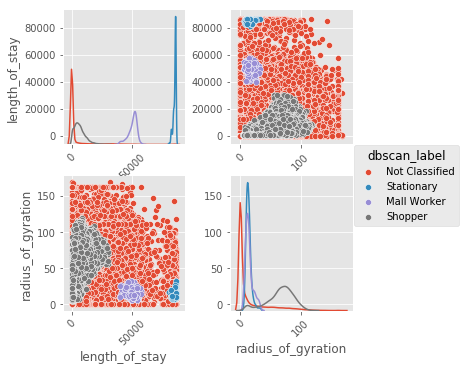

In [31]:
g = sns.pairplot(
    output_mac_address_df[['length_of_stay', 'radius_of_gyration', 'dbscan_label']].dropna(),
    vars=['length_of_stay', 'radius_of_gyration'],
    hue="dbscan_label", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

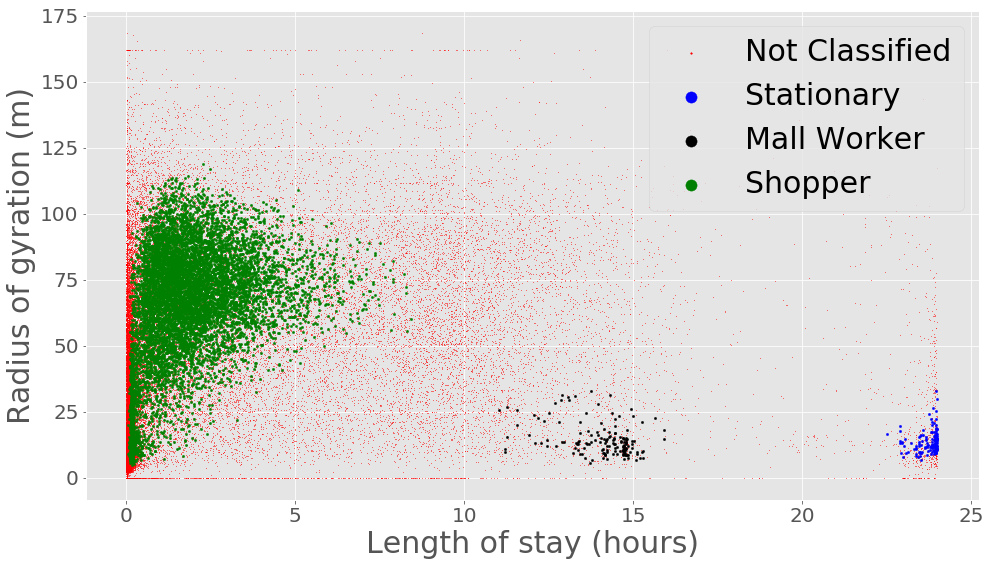

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

labels = output_mac_address_df.dbscan_label.unique()
output_label_group = output_mac_address_df.groupby('dbscan_label')

colours = ['r', 'b', 'k', 'g']

i = 0
for label in labels:
    label_group = output_label_group.get_group(label)
    x = label_group.length_of_stay.as_matrix()
    y = label_group.radius_of_gyration.as_matrix()
    if label == 'Not Classified':
        ax.scatter(x/60/60, y, c=colours[i], label=label, s=0.1)
    else:
        ax.scatter(x/60/60, y, c=colours[i], label=label, s=5)
    i += 1
    
ax.set_xlabel('Length of stay (hours)', fontsize=30)
ax.set_ylabel('Radius of gyration (m)', fontsize=30)
ax.legend(markerscale=5., fontsize=30)
ax.tick_params(labelsize=20)
fig.savefig('dbscan_clustering_example.png', dpi=400)

In [36]:
def plot_histogram_jn(signal_df, axes, minute_resolution=60, label=None):
    """
    This plots the histogram of mac address against time.
    The y axis shows how many mac addresses (devices) where present over during the minute_resolution intervals.

    :param signal_df: (pd.DataFrame) The signals
    :param axes: The figure ax
    :param minute_resolution: (int) The resolution of the time
    :param label: (str) The label of the line
    :return: A plot
    """
    signal_df2 = signal_df.copy()
    signal_df2.date_time = signal_df2.date_time.dt.round(str(minute_resolution) + 'min')
    signal_time_df = signal_df2.groupby('date_time').mac_address.nunique().to_frame()
    if label is not None:
        signal_time_df.rename(columns={'mac_address': label}, inplace=True)

    ax = signal_time_df.plot(ax=axes, fontsize=20)
    ax.set_xlabel('Time (month-day hour)', fontsize=30)
    ax.set_ylabel('Count of devices \n per {} mins (no.)'.format(minute_resolution), fontsize=30)

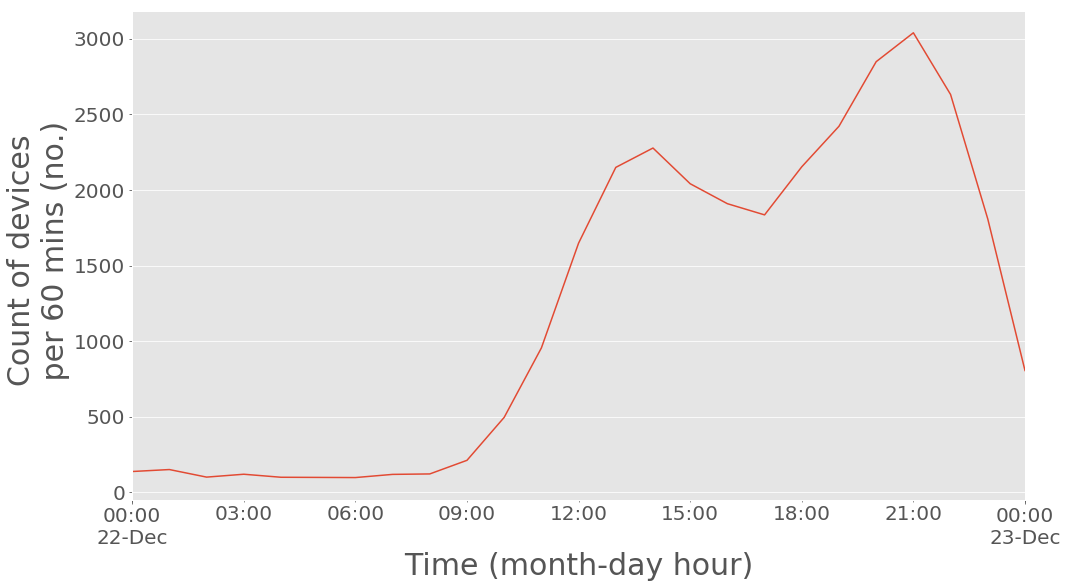

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

macs = mac_address_classified_df[
    (mac_address_classified_df.device == 'Shopper') |
    (mac_address_classified_df.device == 'Stationary') |
    (mac_address_classified_df.device == 'Mall Worker')
].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
);

ax.legend_.remove();

fig.savefig('mac_addresses_15_mins.png', dpi=400)

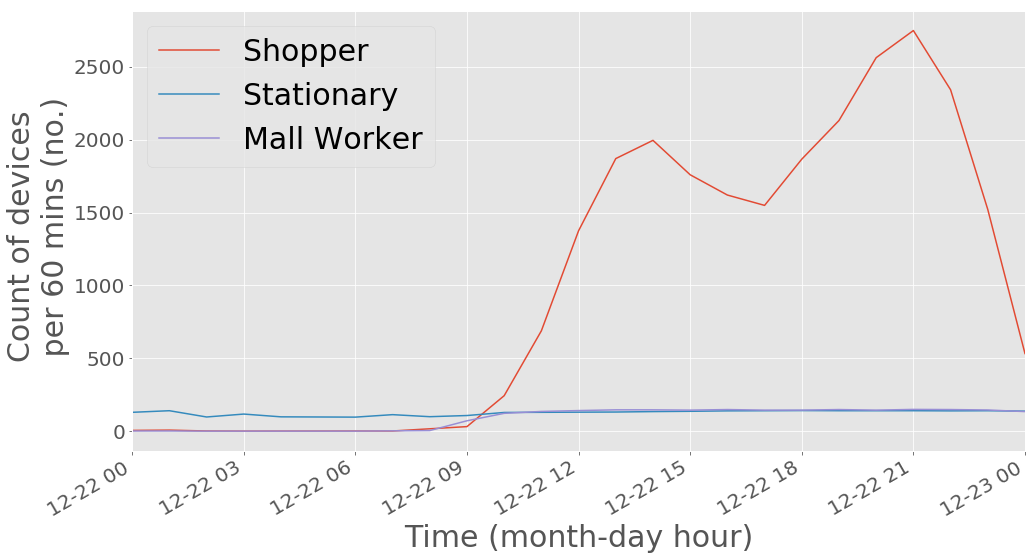

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

macs = mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Shopper',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Stationary',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Mall Worker'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Mall Worker',
);

ax.legend(fontsize=30)

fig.savefig('mac_addresses_15_mins.png', dpi=400)